In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'zindi-geoai-ground-level-no2-estimation-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5270243%2F8770223%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240714%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240714T134437Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31f3bd823e21cedac111978a1e8d9524d468e12ea624e97e1568e04c793706e994e0ff9940d6e19e24a0e365e270f135f1eca47e67e4d5d13695d1cb703bfbc688fe2397bd8ffd1024ec64f7e5edc59b8dd6f25ad68240375c2ccafc1ae35a8da0374dcc71c0eef26a115040520d215071fa7c5bb8442099b5691ddee9f77e07985f70e7c6af2ff4ff5238f38582b5549ed42fdae8662597d519b8f33a405bd753ec946d20eec12316341410bf35aaa71352ed9d18fd94405663f610647685d0ff1b8ff26a320b940cb9bc1ed0994c40ac1fe5f9f9ff00df0131686d88cf3cc644e65d3eabef7ff8aaef7f9e658cf8dd37cc12e73a4cdba6ea01f73108ad2a61'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3366877 bytes downloaded
Downloaded and uncompressed: zindi-geoai-ground-level-no2-estimation-challenge
Data source import complete.


# Importings

- mutual information
- search for the catboost regressor on kaggle

In [6]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
import xgboost as xgb
from sklearn.cluster import KMeans
from path import Path
path = Path('/kaggle/input/zindi-geoai-ground-level-no2-estimation-challenge')
train = pd.read_csv(path /'Train.csv')
test = pd.read_csv(path /'Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)


In [7]:
train = train.dropna(subset=['GT_NO2'])
train.isnull().sum()
#in order to the catboost model to be evaluated

ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   37594
AAI                   12118
CloudFraction         12118
NO2_strat             12118
NO2_total             12118
NO2_trop              33429
TropopausePressure    12118
GT_NO2                    0
dtype: int64

# Feature Engineering

In [8]:
"""agg_funcs = ['mean', 'std', 'min', 'max']

def add_aggregated_features(dataset, columns, funcs):
    dataset = dataset.copy()
    for column in columns:
        agg_features_id = dataset.groupby('ID')[column].agg(funcs)
        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]
        dataset = dataset.merge(agg_features_id, on='ID')
    return dataset
train = add_aggregated_features(train, columns_to_aggregate, agg_funcs)
test = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"""

"agg_funcs = ['mean', 'std', 'min', 'max'] \n\ndef add_aggregated_features(dataset, columns, funcs):\n    dataset = dataset.copy()\n    for column in columns:\n        agg_features_id = dataset.groupby('ID')[column].agg(funcs)\n        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]\n        dataset = dataset.merge(agg_features_id, on='ID')\n    return dataset\ntrain = add_aggregated_features(train, columns_to_aggregate, agg_funcs)\ntest = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"

In [9]:
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [10]:
lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 3
num_clusters_lon = 4
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = int((row['LAT'] - lat_min) / lat_step)
    lon_cluster = int((row['LON'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min
    )
print("Train dataset with clusters:\n", train)
print("\nTest dataset with clusters:\n", test)


Train dataset with clusters:
         ID_Zindi      Date     ID        LAT        LON  Precipitation  \
0      ID_ENTGC7    1/1/19   PD01  45.601585  11.903551       0.000000   
1      ID_8JCCXC    1/1/19   PD04  45.371005  11.840830       3.047342   
2      ID_V3136Z    1/1/19   RO01  45.045825  12.060869       0.000000   
3      ID_KRVZDJ    1/1/19   RO02  45.104075  11.553241       1.200467   
4      ID_PR351A    1/1/19   RO03  45.038758  11.790152       1.274564   
...          ...       ...    ...        ...        ...            ...   
86579  ID_NCWXIY  31-12-21  X9897  45.498227   9.556232       0.000000   
86580  ID_UDQIEE  31-12-21  X9928  45.142541  10.043836       0.000000   
86581  ID_ENDUPX  31-12-21  X9969  45.842207   9.351658       0.000000   
86582  ID_3ZBA6C  31-12-21  X9993  45.113503   8.874065       0.000000   
86583  ID_GWG0LD  31-12-21  X9999  45.526473   9.515980       0.000000   

          LST       AAI  CloudFraction  NO2_strat  NO2_total  NO2_trop  \
0      

In [11]:
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,lat_cluster,lon_cluster
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000,2,3
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000,1,3
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000,0,3
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000,0,2
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750,1,0
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125,0,1
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325,2,0
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250,0,0


In [12]:
"""train = train.sort_values('Date').reset_index(drop=True)
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    #df['target_month'] = df['Month'].map(df[['Month','GT_NO2']].groupby('Month')['GT_NO2'].mean())
    #df['Month_start'] = df['Date'].dt.is_month_start
    #df['Year'] =  df['Date'].dt.year
    #df.set_index(df['Date'],inplace=True)
    #df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df.drop(columns=['ID_Zindi'],inplace=True)

#Linterations
#for df in(train,test):
    #df['NO2_strat_lag_1'] = df['NO2_strat'].shift(1)
    #df['NO2_strat_lag_7'] = df['NO2_strat'].shift(7)
    #df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    #df['Precipitation_log'] =  np.log(df['Precipitation'] + 1e-9)
    #df['CloudFraction_diff'] = df['CloudFraction'] / df['NO2_strat']
    #df['CloudFraction_diff2'] = df['CloudFraction'] / df['NO2_total']
    #['Precipitation_fractional'] = df['Precipitation'] * 0.00001
    #df['TropopausePressure_fractional'] = round(df['TropopausePressure'] * 0.00001,2)
    #df['cluster'] = kmeans.fit_transform(df[['LAT', 'LON']])
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']

#for df in(train,test):
    #Rolling (Moving Average)
    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()
#statsitics of similar variables

"""def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')
MeanSd('LON','LAT')"""

<ipython-input-12-6cbf7266dbfd>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-12-6cbf7266dbfd>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'def MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)\n\nMeanSd(\'NO2_trop\',\'NO2_total\')\nMeanSd(\'LON\',\'LAT\')'

In [13]:
#for df in(train,test):
    #df['LST_mean_60'] = df['LST'].rolling(60).mean()
    #df['Prec_mean_60'] = df['Precipitation'].rolling(60).mean()
    #df['AII_mean'] = df['AAI'].rolling(60).mean()
    #df['no2_total'] = df['NO2_total'].rolling(60).min()

    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()


def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
#rolling('AAI')
#rolling('LST')
rolling('Precipitation')

In [14]:
"""columns_to_aggregate = [
    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat',
    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction',
    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60',
    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'
]
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')
        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')
        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')
        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
for df in (train,test):
    for col in columns_to_aggregate:
        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()
        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()
        df[f'{col}_rolling_max_30'] = df[col].rolling(window=30).max()
        df[f'{col}_rolling_min_30'] = df[col].rolling(window=30).min()"""

"columns_to_aggregate = [\n    'LAT', 'LON', 'distance', 'Precipitation_rolling_max_60', 'NO2_strat', \n    'NO2_total', 'NO2_total_rolling_max_60', 'AAI', 'LST', 'CloudFraction', \n    'TropopausePressure', 'NO2_trop', 'TropopausePressure_rolling_max_60', \n    'CloudFraction_rolling_max_60', 'Precipitation', 'NO2_trop_rolling_max_60'\n]\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_monthly_mean'] = df.groupby('Month')[col].transform('mean')\n        df[f'{col}_monthly_sum'] = df.groupby('Month')[col].transform('sum')\n        df[f'{col}_monthly_max'] = df.groupby('Month')[col].transform('max')\n        df[f'{col}_monthly_min'] = df.groupby('Month')[col].transform('min')\n\ndf['Date'] = pd.to_datetime(df['Date'])\ndf = df.set_index('Date')\nfor df in (train,test):\n    for col in columns_to_aggregate:\n        df[f'{col}_rolling_mean_30'] = df[col].rolling(window=30).mean()\n        df[f'{col}_rolling_sum_30'] = df[col].rolling(window=30).sum()\n  

# Missing Values & Encoding

In [15]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=["Date",'ID','Precipitation','CloudFraction','AAI'], axis=1,inplace=True)

le = LabelEncoder()
for df in(train,test):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])

# CV and Modeling

In [16]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lat_cluster', 'lon_cluster', 'Month',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')

In [17]:
#model =  LGBMRegressor(random_state=7)
from catboost import CatBoostRegressor
from xgboost import XGBRFRegressor
model = XGBRFRegressor(random_state=7)
model = CatBoostRegressor(random_state=7)
model = XGBRegressor(random_state= 7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)

    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)
print('RMSEs Deviations:', rmse)

Streaming output truncated to the last 5000 lines.
18:	learn: 11.8486306	total: 367ms	remaining: 19s
19:	learn: 11.7663735	total: 380ms	remaining: 18.6s
20:	learn: 11.6847528	total: 392ms	remaining: 18.3s
21:	learn: 11.6031172	total: 412ms	remaining: 18.3s
22:	learn: 11.5093179	total: 429ms	remaining: 18.2s
23:	learn: 11.4443804	total: 448ms	remaining: 18.2s
24:	learn: 11.3586827	total: 465ms	remaining: 18.1s
25:	learn: 11.3021625	total: 477ms	remaining: 17.9s
26:	learn: 11.2518985	total: 490ms	remaining: 17.7s
27:	learn: 11.2057976	total: 504ms	remaining: 17.5s
28:	learn: 11.1545811	total: 516ms	remaining: 17.3s
29:	learn: 11.1146036	total: 528ms	remaining: 17.1s
30:	learn: 11.0489599	total: 540ms	remaining: 16.9s
31:	learn: 11.0104002	total: 556ms	remaining: 16.8s
32:	learn: 10.9660954	total: 571ms	remaining: 16.7s
33:	learn: 10.9166507	total: 584ms	remaining: 16.6s
34:	learn: 10.8886911	total: 597ms	remaining: 16.5s
35:	learn: 10.8405939	total: 612ms	remaining: 16.4s
36:	learn: 10.8

In [18]:
#10.155311364148783 catboost leaderboard best s far 9.525616244
#9.920018431939276 catboost and added the day features - probably it overfits - indeed
#9.43514150859055 removing all missing values leaderboard 11.9315086
#10.139203906659699
#10.201862135497844 the effect of mutual information
#9.476601295728365
#10.025125392453269

In [19]:
#11.581549939504997 with month ,
#12.246931687286574
#12.235259341356834
#12.231869616518921
#12.126333476852636
#11.728753513719479
#11.724263538742687
#11.728753513719479
#11.711277895239192
#11.694341231865433
#11.671982426722977
#11.642227859275334 without the mean - with the custamized means of rolling
#11.314985626750522
#11.314985626750522
#11.312413659993586
#11.135932399851725
#11.728753513719479 best so far features = ['LAT', 'Month','NO2_trop_rolling_max_60','NO2_total_rolling_max_60','TropopausePressure_rolling_max_60','CloudFraction_rolling_max_60','Precipitation_rolling_max_60']
#11.40320255907346 with the ID LB = 9.571700669
#11.597286160951526 the distance feature

In [21]:
import contextlib, os,sys
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Removed feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def lofo_analysis(train, target_col, groups, n_splits):
    base_rmse = []
    for train_idx, test_idx in cv.split(train.drop(columns=target_col), train[target_col], groups=groups):
        train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
        base_rmse.append(validate(train_v, test_v, target_col))
    base_score = np.array(base_rmse).mean()
    print('Base RMSE:', base_score)

    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train.drop(columns=[target_col, col]), train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v.drop(columns=col), test_v.drop(columns=col), target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} removed, RMSE: {feature_rmse}')

    bad_features = [col for col in feature_importances if feature_importances[col] > base_score]
    good_features = [col for col in feature_importances if feature_importances[col] <= base_score]

    print('Good features:', good_features)
    print('Bad features:', bad_features)

    return good_features, bad_features, feature_importances

good_features, bad_features, feature_importances = lofo_analysis(train, 'GT_NO2', groups, n_splits)

print('Feature importances:')
for feature, importance in feature_importances.items():
    print(f'{feature}: {importance}')

Validation MSE: 9.800302010756905
Validation MSE: 11.330967326411427
Validation MSE: 10.223994278193013
Validation MSE: 9.665192084327796
Validation MSE: 9.105171262577208
Base RMSE: 10.025125392453269
Evaluating feature: LAT
Removed feature: LAT | Validation MSE: 10.395415267288977
Removed feature: LAT | Validation MSE: 12.795991173349453
Removed feature: LAT | Validation MSE: 10.932310455777523
Removed feature: LAT | Validation MSE: 11.924599506791305
Removed feature: LAT | Validation MSE: 10.067872433951736
Feature LAT removed, RMSE: 11.2232377674318
Evaluating feature: LON
Removed feature: LON | Validation MSE: 12.412209799634311
Removed feature: LON | Validation MSE: 12.124953843008527
Removed feature: LON | Validation MSE: 11.452227170396885
Removed feature: LON | Validation MSE: 10.327379840766834
Removed feature: LON | Validation MSE: 10.27957487233013
Feature LON removed, RMSE: 11.319269105227338
Evaluating feature: LST
Removed feature: LST | Validation MSE: 10.287615583092057

In [ ]:
bad_features

In [ ]:
"""@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using features: NO2_total, NO2_trop, {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score
def feature_combination_analysis(train, target_col, groups, n_splits):
    base_features = ['NO2_total', 'NO2_trop']
    additional_features = [col for col in train.drop(columns=target_col).columns if col not in base_features]

    feature_importances = {}
    for col in additional_features:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train[[target_col] + base_features + [col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col] + base_features + [col]], test_v[[target_col] + base_features + [col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} with base features, RMSE: {feature_rmse}')
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')

    return feature_importances

feature_importances = feature_combination_analysis(train, 'GT_NO2', groups, n_splits)"""

In [ ]:
"""@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output():
        model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    if feature_name:
        print(f'Using feature: {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score

def single_feature_analysis(train, target_col, groups, n_splits):
    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in cv.split(train[[target_col, col]], train[target_col], groups=groups):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v[[target_col, col]], test_v[[target_col, col]], target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} only, RMSE: {feature_rmse}')
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')

    return feature_importances
feature_importances = single_feature_analysis(train, 'GT_NO2', groups, n_splits)"""

In [ ]:
hshsd

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y = model.predict(test)
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/SampleSubmission.csv')
smaple['GT_NO2'] = post_process(test,y)
smaple.to_csv('submissionpost2.csv',index=False)

In [22]:
for df in(train,test):
  df.drop(columns=['lat_cluster'], axis=1,inplace=True)

In [23]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')

In [24]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('submission10016482406802602.csv', index=False)

Learning rate set to 0.082149
0:	learn: 16.4093300	total: 24.9ms	remaining: 24.8s
1:	learn: 15.8181104	total: 61.6ms	remaining: 30.8s
2:	learn: 15.2869420	total: 100ms	remaining: 33.3s
3:	learn: 14.8069038	total: 143ms	remaining: 35.5s
4:	learn: 14.3936428	total: 176ms	remaining: 34.9s
5:	learn: 14.0042278	total: 219ms	remaining: 36.3s
6:	learn: 13.6630512	total: 257ms	remaining: 36.4s
7:	learn: 13.3577060	total: 300ms	remaining: 37.3s
8:	learn: 13.1016609	total: 343ms	remaining: 37.8s
9:	learn: 12.8826345	total: 381ms	remaining: 37.7s
10:	learn: 12.6825085	total: 417ms	remaining: 37.5s
11:	learn: 12.5038209	total: 459ms	remaining: 37.8s
12:	learn: 12.3465315	total: 497ms	remaining: 37.8s
13:	learn: 12.1799680	total: 537ms	remaining: 37.8s
14:	learn: 12.0494906	total: 580ms	remaining: 38.1s
15:	learn: 11.9404243	total: 618ms	remaining: 38s
16:	learn: 11.8249218	total: 666ms	remaining: 38.5s
17:	learn: 11.7133695	total: 707ms	remaining: 38.5s
18:	learn: 11.6215983	total: 743ms	remaining

In [25]:
model.feature_importances_

array([19.2329038 , 17.57567004,  1.96036604, 22.40826838, 12.3750379 ,
        3.45857254,  2.25687327,  0.49839136,  5.88027797,  0.52788899,
        3.57010126,  1.91393331,  1.37318909,  6.96852607])

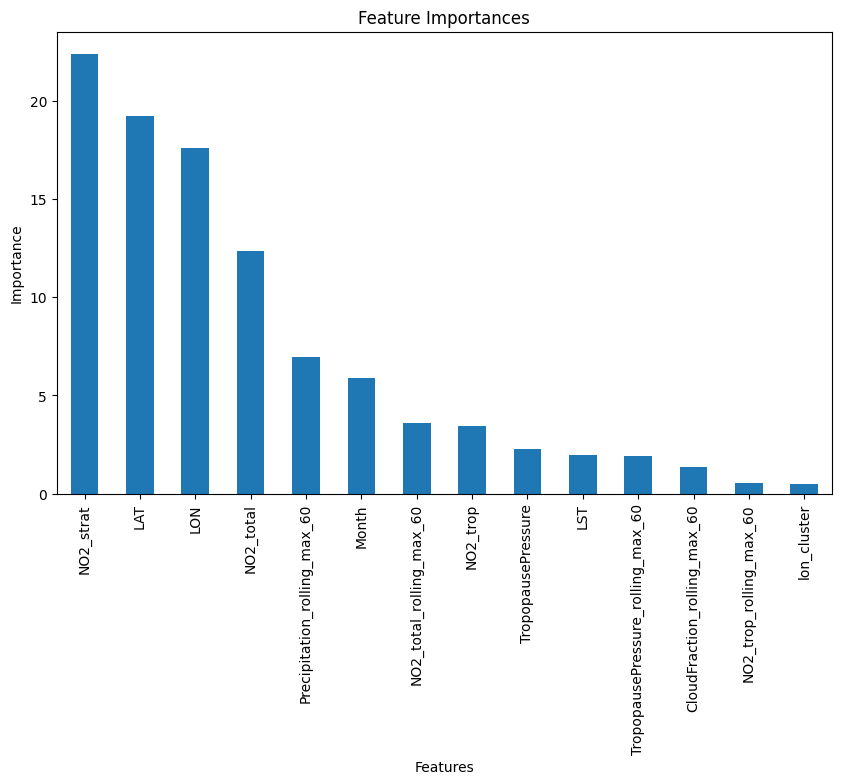

In [26]:
importances = model.feature_importances_
names = model.feature_names_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [27]:
train.columns

Index(['LAT', 'LON', 'LST', 'NO2_strat', 'NO2_total', 'NO2_trop',
       'TropopausePressure', 'GT_NO2', 'lon_cluster', 'Month',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')